In [1]:
from utils import *
import pickle

In [2]:
class PointwiseLinear(torch.nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim):
        super().__init__()

        self.W1 = torch.nn.Parameter(torch.rand(output_feature_dim, 5, 1, input_feature_dim))
        self.W2 = torch.nn.Parameter(torch.rand(output_feature_dim, 5, 1, output_feature_dim * 4))
        self.W3 = torch.nn.Parameter(torch.rand(output_feature_dim, 5, 1, output_feature_dim * 2))
        
        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)
        torch.nn.init.xavier_uniform_(self.W3)
        
        self.fc1 = torch.nn.Linear(input_feature_dim, output_feature_dim * 4)
        self.fc2 = torch.nn.Linear(output_feature_dim * 4, output_feature_dim * 2)
        self.fc3 = torch.nn.Linear(output_feature_dim * 2, output_feature_dim)       
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        out = self.relu(self.W1 * x) #().mean(dim=(-2, -1))
        out = self.fc1(out)
        out = self.relu(self.W2 * out)
        out = self.fc2(out)
        out = self.relu(self.W3 * out)
        out = (self.fc3(out)).mean(dim=(0, 2))
        
        return out

In [3]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(
            16,
            self.hidden_size,
            self.num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )
        
        self.feature_extractor = PointwiseLinear(self.input_size, 16)
        self.fc_1 = nn.Linear(self.hidden_size + 9, self.hidden_size)
        
        #TODO: reduce the size of the dense net below
        self.fc_2 = nn.Sequential(
            nn.Linear(self.hidden_size // 1, self.hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(self.hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 4, self.hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 8, self.output_size),
        )
    

    def forward(self, x, x_target):
        
        # B x T x N x F
        
        B = len(x)
        T = len(x[0])
        
        features = []
        
        for i in range(B):
            
            time_features = []
            extracted_features = self.feature_extractor(x[i].to(dtype=torch.float32, device=DEVICE))
            features.append(extracted_features)
        
        features = torch.stack(features, dim=0)
        lstm_features, _ = self.lstm(features)
        lstm_features = lstm_features[:, -1, ...]
        
        x_target = torch.from_numpy(np.stack(x_target).astype(np.float32)).to(dtype=torch.float32, device=DEVICE)
        combined_features = torch.cat([lstm_features, x_target], dim=-1)
            
        out = self.fc_1(combined_features)
        out = self.fc_2(out)
        
        return out

In [4]:
model = LSTMModel(input_size=78, hidden_size=512, num_layers=5, output_size=1).to(DEVICE)

In [5]:
with open('./data/X_train_lstm_pad_06_09.pt', 'rb') as file:
    X_train = pickle.load(file)
    
with open('./data/x_train_lstm_pad_06_09.pt', 'rb') as file:
    x_train = pickle.load(file)
    
with open('./data/y_train_lstm_pad_06_09.pt', 'rb') as file:
    y_train = pickle.load(file)    

In [6]:
with open('./data/X_val_lstm_pad_06_09.pt', 'rb') as file:
    X_val = pickle.load(file)
    
with open('./data/x_val_lstm_pad_06_09.pt', 'rb') as file:
    x_val = pickle.load(file)
    
with open('./data/y_val_lstm_pad_06_09.pt', 'rb') as file:
    y_val = pickle.load(file)    

In [7]:
indices = list(range(len(X_train)))

In [8]:
BATCH_SIZE = 64
NUM_EPOCHS = 60

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [10]:
# model_name = input("Input proper model name:\t")
model_name = '07_09_T2'

val_min_loss = None

history = []

for epoch_index in range(NUM_EPOCHS):
    shuffle(X_train, x_train, y_train)
    
    running_loss_train = 0.0
    model.train()

    for batch_index in tqdm(range(len(X_train)//BATCH_SIZE)):
        X_train_batch = []
        x_train_batch = []
        y_train_batch = []
        
        for item_index in range(BATCH_SIZE):
            X_train_batch.append(X_train[BATCH_SIZE*batch_index + item_index])
            x_train_batch.append(x_train[BATCH_SIZE*batch_index + item_index])
            y_train_batch.append(y_train[BATCH_SIZE*batch_index + item_index])
            
        optimizer.zero_grad()
        y_train_prediction = model(X_train_batch, x_train_batch)
        
        y_train_batch = torch.from_numpy(np.stack(y_train_batch)).to(dtype=torch.float32, device=DEVICE)
        loss = criterion(y_train_batch.view(-1, 1), y_train_prediction)
        
        loss.backward()
        optimizer.step()
        
        running_loss_train += loss.item()
    
    mean_train_loss = running_loss_train / (len(X_train) / BATCH_SIZE)
    
    
    with torch.no_grad():
        
        running_loss_val = 0.0
        model.eval()
        for batch_index in tqdm(range(len(X_val)//BATCH_SIZE)):
            X_val_batch = []
            x_val_batch = []
            y_val_batch = []

            for item_index in range(BATCH_SIZE):

                X_val_batch.append(X_val[BATCH_SIZE*batch_index + item_index])
                x_val_batch.append(x_val[BATCH_SIZE*batch_index + item_index])
                y_val_batch.append(y_val[BATCH_SIZE*batch_index + item_index])

            
            y_val_batch = torch.from_numpy(np.stack(y_val_batch)).to(dtype=torch.float32, device=DEVICE)
            y_val_prediction = model(X_val_batch, x_val_batch)
            loss = criterion(y_val_batch.view(-1, 1), y_val_prediction)
            
            running_loss_val += loss.item()
        mean_val_loss = running_loss_val / (len(X_val) / BATCH_SIZE)
        
        
    if val_min_loss is None:
        val_min_loss = mean_val_loss
    elif mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        torch.save(model.state_dict(), f"./models/{model_name}.pth")
        
    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch_index+1}/{NUM_EPOCHS}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )        

100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.90it/s]


Epoch [1/60]
Train Loss: 0.038
Val Loss: 0.0324


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.50it/s]


Epoch [2/60]
Train Loss: 0.0351
Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 56.69it/s]


Epoch [3/60]
Train Loss: 0.0345
Val Loss: 0.0308


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 55.50it/s]


Epoch [4/60]
Train Loss: 0.0341
Val Loss: 0.0308


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.84it/s]


Epoch [5/60]
Train Loss: 0.0338
Val Loss: 0.0305


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 47.25it/s]


Epoch [6/60]
Train Loss: 0.0336
Val Loss: 0.0304


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.42it/s]


Epoch [7/60]
Train Loss: 0.0334
Val Loss: 0.0303


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 46.19it/s]


Epoch [8/60]
Train Loss: 0.0332
Val Loss: 0.0302


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.40it/s]


Epoch [9/60]
Train Loss: 0.033
Val Loss: 0.0302


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.54it/s]


Epoch [10/60]
Train Loss: 0.0329
Val Loss: 0.0301


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.32it/s]


Epoch [11/60]
Train Loss: 0.0327
Val Loss: 0.03


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.32it/s]


Epoch [12/60]
Train Loss: 0.0326
Val Loss: 0.0301


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 46.06it/s]


Epoch [13/60]
Train Loss: 0.0325
Val Loss: 0.0302


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.84it/s]


Epoch [14/60]
Train Loss: 0.0324
Val Loss: 0.0299


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.38it/s]


Epoch [15/60]
Train Loss: 0.0322
Val Loss: 0.03


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.26it/s]


Epoch [16/60]
Train Loss: 0.0321
Val Loss: 0.03


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.38it/s]


Epoch [17/60]
Train Loss: 0.0321
Val Loss: 0.0298


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.14it/s]


Epoch [18/60]
Train Loss: 0.032
Val Loss: 0.0299


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.87it/s]


Epoch [19/60]
Train Loss: 0.0319
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.62it/s]


Epoch [20/60]
Train Loss: 0.0318
Val Loss: 0.0298


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.95it/s]


Epoch [21/60]
Train Loss: 0.0317
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.16it/s]


Epoch [22/60]
Train Loss: 0.0316
Val Loss: 0.0299


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 57.91it/s]


Epoch [23/60]
Train Loss: 0.0315
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.32it/s]


Epoch [24/60]
Train Loss: 0.0314
Val Loss: 0.0296


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.37it/s]


Epoch [25/60]
Train Loss: 0.0313
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 47.13it/s]


Epoch [26/60]
Train Loss: 0.0312
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.69it/s]


Epoch [27/60]
Train Loss: 0.0312
Val Loss: 0.0296


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.45it/s]


Epoch [28/60]
Train Loss: 0.0311
Val Loss: 0.0296


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.52it/s]


Epoch [29/60]
Train Loss: 0.031
Val Loss: 0.0297


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 48.75it/s]


Epoch [30/60]
Train Loss: 0.0309
Val Loss: 0.0296


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.67it/s]


Epoch [31/60]
Train Loss: 0.0308
Val Loss: 0.0296


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.89it/s]


Epoch [32/60]
Train Loss: 0.0308
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.29it/s]


Epoch [33/60]
Train Loss: 0.0307
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 47.08it/s]


Epoch [34/60]
Train Loss: 0.0306
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.62it/s]


Epoch [35/60]
Train Loss: 0.0305
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.03it/s]


Epoch [36/60]
Train Loss: 0.0305
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.80it/s]


Epoch [37/60]
Train Loss: 0.0304
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.39it/s]


Epoch [38/60]
Train Loss: 0.0303
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 58.71it/s]


Epoch [39/60]
Train Loss: 0.0302
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.21it/s]


Epoch [40/60]
Train Loss: 0.0301
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.40it/s]


Epoch [41/60]
Train Loss: 0.0301
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.54it/s]


Epoch [42/60]
Train Loss: 0.03
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.06it/s]


Epoch [43/60]
Train Loss: 0.0299
Val Loss: 0.0292


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.36it/s]


Epoch [44/60]
Train Loss: 0.0298
Val Loss: 0.0292


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.12it/s]


Epoch [45/60]
Train Loss: 0.0297
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.31it/s]


Epoch [46/60]
Train Loss: 0.0297
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.38it/s]


Epoch [47/60]
Train Loss: 0.0296
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.63it/s]


Epoch [48/60]
Train Loss: 0.0295
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.99it/s]


Epoch [49/60]
Train Loss: 0.0295
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.40it/s]


Epoch [50/60]
Train Loss: 0.0294
Val Loss: 0.0292


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.24it/s]


Epoch [51/60]
Train Loss: 0.0293
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.75it/s]


Epoch [52/60]
Train Loss: 0.0292
Val Loss: 0.0292


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.96it/s]


Epoch [53/60]
Train Loss: 0.0291
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 42.75it/s]


Epoch [54/60]
Train Loss: 0.0291
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.48it/s]


Epoch [55/60]
Train Loss: 0.0289
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.38it/s]


Epoch [56/60]
Train Loss: 0.0289
Val Loss: 0.0294


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.51it/s]


Epoch [57/60]
Train Loss: 0.0288
Val Loss: 0.0295


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.71it/s]


Epoch [58/60]
Train Loss: 0.0287
Val Loss: 0.0292


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.32it/s]


Epoch [59/60]
Train Loss: 0.0286
Val Loss: 0.0293


100%|████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 45.27it/s]

Epoch [60/60]
Train Loss: 0.0286
Val Loss: 0.0292


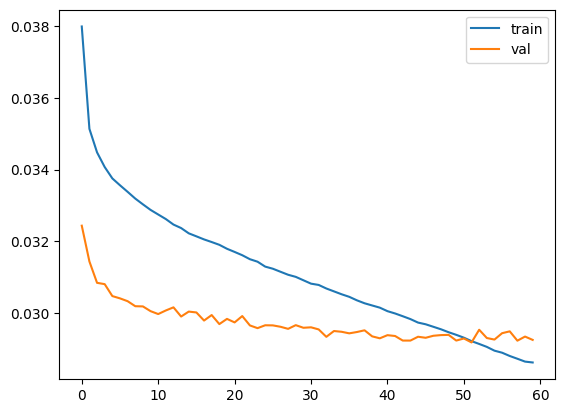

In [17]:
plt.plot(history)
plt.legend(["train", "val"]);

### Evaluation

In [18]:
model.load_state_dict(torch.load(f"./models/{model_name}.pth"))
model.eval()
prediction = model(X_val, x_val).detach().cpu().numpy()[..., 0]
ground_truth = np.array(y_val)

In [19]:
# MAE
print(np.abs(prediction - ground_truth).mean().round(4))

0.1318


In [20]:
# MSE
np.round((criterion(torch.from_numpy(prediction[..., None]), torch.from_numpy(ground_truth[..., None])).item()), 4)

0.0297

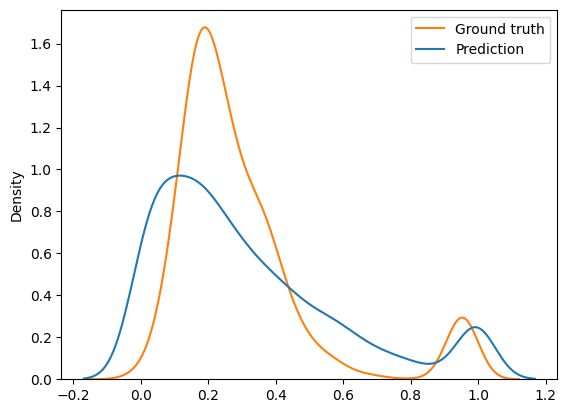

In [21]:
# KDE plot
sns.kdeplot([ground_truth, prediction])
plt.legend(["Ground truth", "Prediction"]);

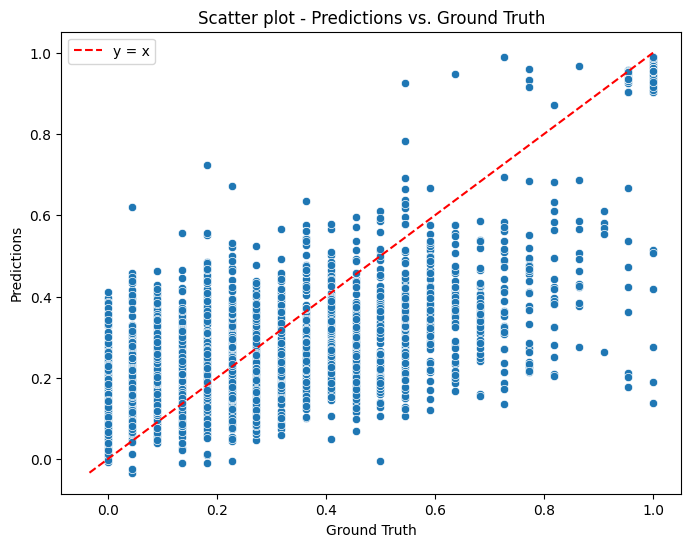

In [22]:
# Scatter plot

# Create a diagonal line for y = x
x_values = np.linspace(
    min(prediction.min(), ground_truth.min()),
    max(prediction.max(), ground_truth.max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth, y=prediction)

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()